### 📝 Learning goals of practical

- You can describe how to apply hierarchical clustering to a transcriptomics dataset

- You can discuss the goals of unsupervised machine learning when applied to transcriptomics data

In this practical, we will explore RNA-seq data from the study:

*High-Throughput RNA Sequencing of Pseudomonas-Infected Arabidopsis Reveals Hidden Transcriptome Complexity and Novel Splice Variants* by [Howard et al. (2013)](https://doi.org/10.1371/journal.pone.0074183)

### ❓Questions
Have a look at the paper.

- What three treatments are the plants subjected to?

- What is the goal of these three treatments?

In [ ]:
# These cells set up everything

# %pip install -q observable_jupyter==0.1.10 clustergrammer2 fastcluster

import sys
if "google.colab" in sys.modules:
    %pip install git+https://github.com/CropXR/EduXR.git
else:
    %load_ext autoreload
    %autoreload 2

from clustergrammer2 import net
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from observable_jupyter import embed
import pandas as pd
from IPython.display import Javascript

def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

!wget https://raw.githubusercontent.com/CropXR/EduXR/refs/heads/main/data/biotic_transcriptomics.txt
net.load_file('biotic_transcriptomics.txt')
net.cluster(dist_type='correlation', linkage_type='average')

>> clustergrammer2 backend version 0.18.0


/home/bnoordijk/mambaforge/envs/ds_c1/lib/python3.12/site-packages/observable_jupyter/jupyter_embed.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


--2025-09-02 10:35:52--  https://raw.githubusercontent.com/CropXR/EduXR/refs/heads/main/data/biotic_transcriptomics.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96646 (94K) [text/plain]
Saving to: ‘biotic_transcriptomics.txt.3’

biotic_transcriptom 100%[===================>]  94.38K  --.-KB/s    in 0.01s   

2025-09-02 10:35:52 (6.39 MB/s) - ‘biotic_transcriptomics.txt.3’ saved [96646/96646]



Now we can display a heatmap of the samples and their (normalised) gene expressions:

Error in callback <function resize_colab_cell at 0x78a2fc4427a0> (for pre_run_cell), with arguments args (<ExecutionInfo object at 78a2fc4dbe00, raw_cell="plt.figure(figsize=(10, 10))
df = pd.read_csv('bio.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/bnoordijk/vscode_projects/EduXR_minor/notebooks/W2_Practical_1_Biotic_transcriptomics.ipynb#W5sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: resize_colab_cell() takes 0 positional arguments but 1 was given

<Figure size 1000x1000 with 0 Axes>

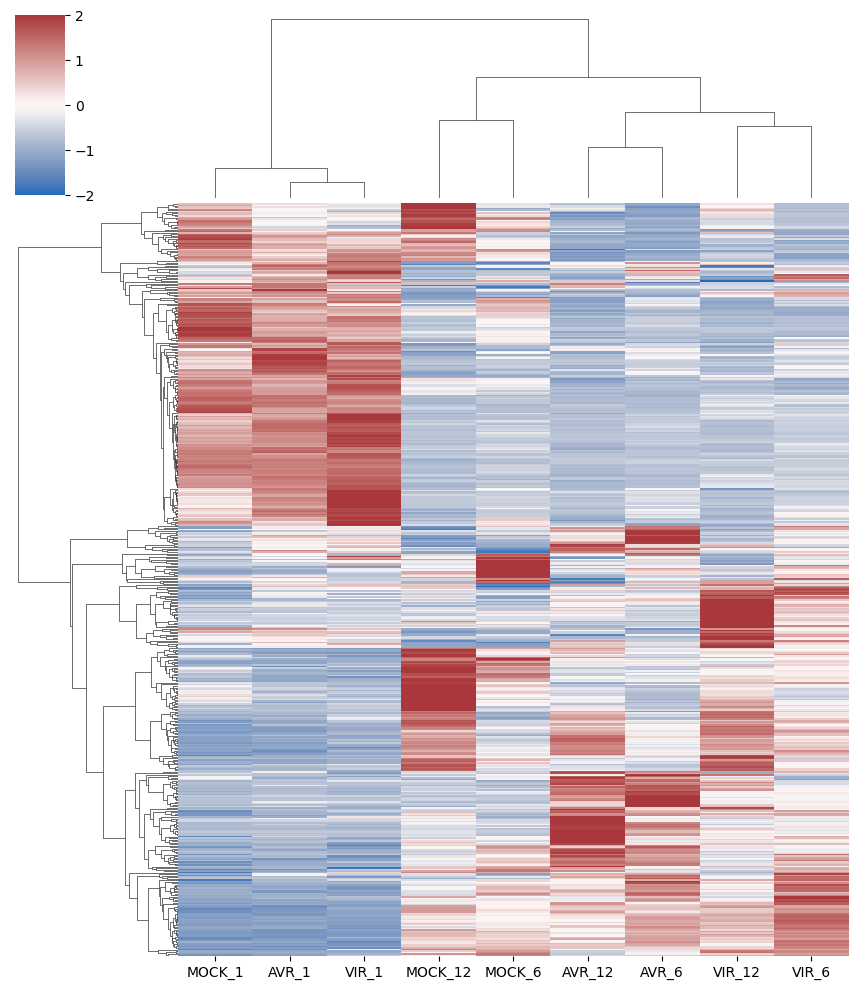

In [2]:
plt.figure(figsize=(10, 10))
df = pd.read_csv('biotic_transcriptomics.txt', sep='\t', header=[0], index_col=0, skiprows=[1,2])
g= sns.clustermap(df, metric='correlation', method='average', cmap="vlag", vmin=-2, vmax=2)
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
plt.show()

### ❓Questions

- Is the avirulent sample more similar to the virulent sample or the mock sample?

- Does the treatment or the time point play a bigger role for clustering the samples?

- Could you explain the clustering? What does it tell you about the relation between the samples?

We can also show you an interactive plot of this. Adjust the sliders on the right and bottom to find the clustering cutoff. By clicking on the trapezoid that belongs to a cluster you can select the group of genes.

In [ ]:
embed('@cornhundred/clustergrammer-gl', cells=['clustergrammer'],  inputs={'network': net.viz})

### ❓Questions
- How many gene clusters do you think is most appropriate for this dataset? Why?

- Change the clustering parameters, what differences do you observe?

- What group(s) of genes would be most interesting to study?


If you have extra time you can further investigate through what biological process the genes you found are important for stress response, for example by looking at their annotations on databases such as [UniProt](https://www.uniprot.org/). Can you link the genes to certain metabolites/processes? How does that relate to what you find in literature about this response?

## Clustering

Error in callback <function resize_colab_cell at 0x78a2fc4427a0> (for pre_run_cell), with arguments args (<ExecutionInfo object at 78a281d0f4a0, raw_cell="import networkx as nx

# 1. Compute correlation ma.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/bnoordijk/vscode_projects/EduXR_minor/notebooks/W2_Practical_1_Biotic_transcriptomics.ipynb#X15sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: resize_colab_cell() takes 0 positional arguments but 1 was given

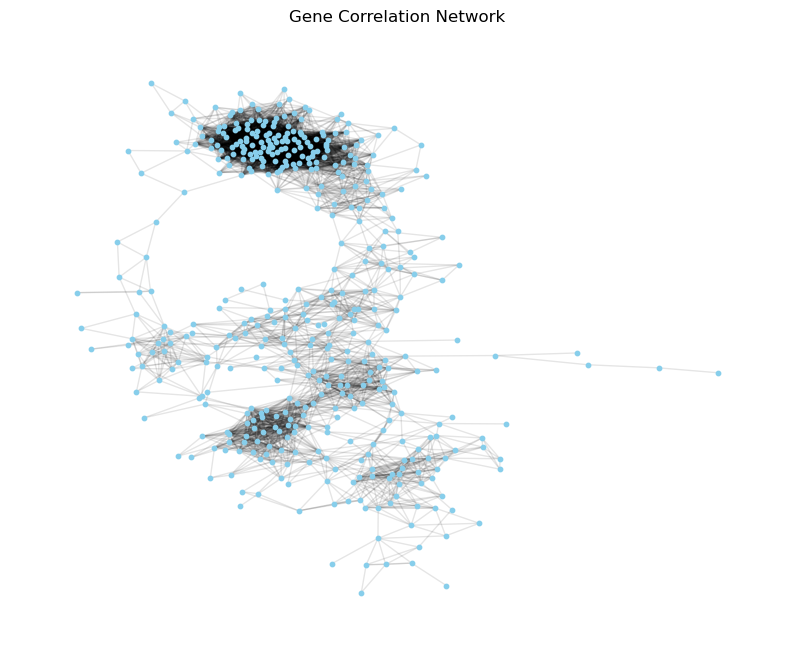

In [31]:
import networkx as nx

# 1. Compute correlation matrix
corr_matrix = df.T.corr(method="pearson")  # transpose so genes correlate across samples

# 2. Threshold correlations (you don’t want every edge, it’d be spaghetti)
threshold = 0.9
edges = [
    (gene1, gene2, corr_matrix.loc[gene1, gene2])
    for gene1 in corr_matrix.index
    for gene2 in corr_matrix.columns
    if gene1 < gene2 and corr_matrix.loc[gene1, gene2] > threshold
]

# 3. Build network
G = nx.Graph()
G.add_weighted_edges_from(edges)

# 4. Plot
plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="skyblue")
nx.draw_networkx_edges(G, pos, alpha=0.1)
# nx.draw_networkx_labels(G, pos, font_size=6)
plt.title("Gene Correlation Network")
plt.axis("off")
plt.show()

In [ ]:
# Assume df and G already exist from before

# Compute centrality (pick one)
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Choose which metric to use for colouring
node_color_metric = degree_centrality  # or betweenness_centrality

# Print top 10 genes by this metric
top10 = sorted(node_color_metric.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 genes by centrality:")
for gene, value in top10:
    print(f"{gene}: {value:.4f}")

# Normalise colours for plotting
values = [node_color_metric[node] for node in G.nodes()]
plt.figure(figsize=(10, 8))
pos = nx.kamada_kawai_layout(G)

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=10,
    node_color=values,
    cmap=plt.cm.viridis
)
nx.draw_networkx_edges(G, pos, alpha=0.1)
# nx.draw_networkx_labels(G, pos, font_size=6)

plt.colorbar(nodes, label="Centrality")
plt.title("Gene Correlation Network (coloured by centrality)")
plt.axis("off")
plt.show()

Error in callback <function resize_colab_cell at 0x78a2fc4427a0> (for pre_run_cell), with arguments args (<ExecutionInfo object at 78a2902ec620, raw_cell="# Assume df and G already exist from before

# Com.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://wsl%2Bubuntu/home/bnoordijk/vscode_projects/EduXR_minor/notebooks/W2_Practical_1_Biotic_transcriptomics.ipynb#X16sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: resize_colab_cell() takes 0 positional arguments but 1 was given

Top 10 genes by centrality:
Gene: at3g50970: 0.2500
Gene: at5g52310: 0.2433
Gene: at1g76680: 0.2411
Gene: at5g16010: 0.2388
Gene: at3g25760: 0.2388
Gene: at3g23820: 0.2388
Gene: at2g20630: 0.2366
Gene: at1g20440: 0.2366
Gene: at1g10370: 0.2366
Gene: at4g20860: 0.2344
